In [115]:
import sys
sys.path.append('../')

import jax
from jax import numpy as jnp, vmap, jit, grad, random
from src.alignment_vmap import fix_point_iter, align
from jax.numpy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt


### Setup

In [116]:
d = 129
N=int(1e4)
std_dev = 2.

np.random.seed(4)

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
#x = (t < np.pi).astype(float) 
x = np.arange(d) == 0
#x = np.exp(4 * jnp.sin(t))
#x = x / np.linalg.norm(x) * np.sqrt(d)

shift = np.random.randint(0, d, N)
y = np.vstack([jnp.roll(x, s) for s in shift])
y = y + np.random.randn(*y.shape) * std_dev

## FOURIER TRANSFORM
xfft = fft(x)
yfft = fft(y, axis=1)

# Moments
acf_fft = jnp.clip(jnp.mean(np.abs(yfft)**2, axis=0) - std_dev **2 * d, 0, None)
mean = jnp.mean(yfft[:, 0])

# Filtered true
d_cutoff = 5
xfft_smooth1 = xfft.at[d_cutoff:-d_cutoff].set(0.)
x_smooth1 = ifft(xfft_smooth1).real

d_cutoff = 25
xfft_smooth2 = xfft.at[d_cutoff:-d_cutoff].set(0.)
x_smooth2 = ifft(xfft_smooth2).real

d_cutoff = 12
xfft_sharp = xfft.at[:d_cutoff].set(0.)
xfft_sharp = xfft_sharp.at[-d_cutoff:].set(0.)
x_sharp = ifft(xfft_sharp).real


### How much does Initialisation matter?

In [117]:
names = ['zero', 'sample', 'true', 'smoothed true', 'more smoothed true', 'sharpened true', 'random']
x0_list = [jnp.zeros(d), y[0, :].copy(), x, x_smooth1, x_smooth2, x_sharp, np.random.randn(d)]

class Counter():
    def __init__(self):
        self.count = 0
    
    def __call__(self, *args, **kwargs):
        self.count += 1
        pass
    
    def reset(self):
        self.count = 0

counter = Counter()

In [118]:
xk_list = []
counts = []

for x0 in x0_list:
    xk = ifft(fix_point_iter(fft(x0), yfft, acf_fft, mean, alpha=1., tol=1e-12, maxiter=800, callback=counter))
    xk = align(fft(x), fft(xk), xk)
    xk_list.append(xk)
    counts.append(counter.count)
    counter.reset()

/home/emastr/anaconda3/envs/jax/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<BarContainer object of 7 artists>

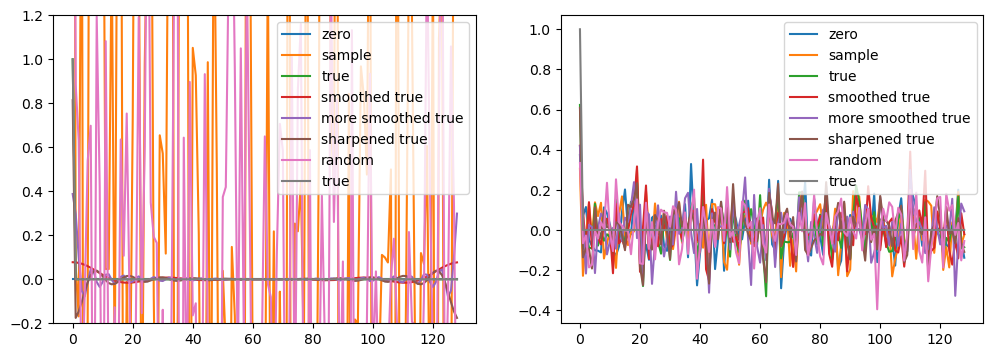

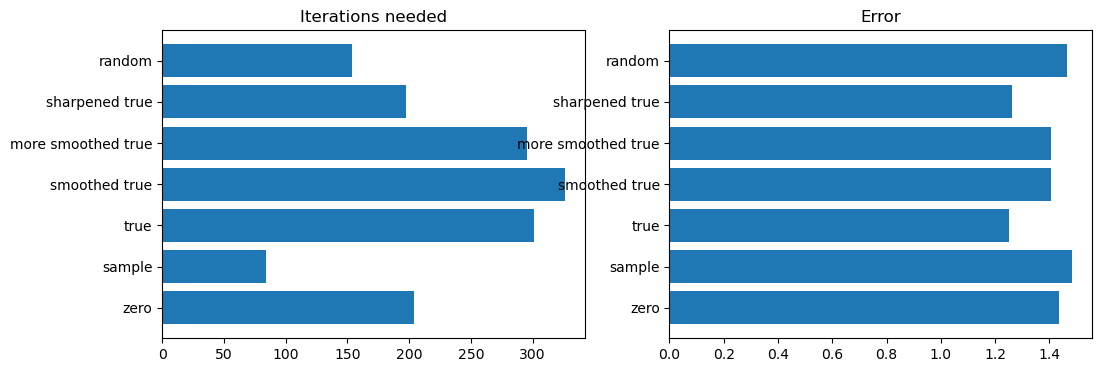

In [119]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
for i, x0 in enumerate(x0_list):
    x0 = align(fft(x), fft(x0), x0)
    plt.plot(x0, label=names[i])
plt.plot(x, label='true')
plt.ylim([-0.2, 1.2])
plt.legend()

plt.subplot(122)
for i, xk in enumerate(xk_list):
    plt.plot(xk, label=names[i])
plt.plot(x, label='true')
plt.legend()

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title('Iterations needed')
plt.barh(names, counts)

plt.subplot(122)
plt.title('Error')
errors = [np.linalg.norm(xk - x) for xk in xk_list]
plt.barh(names, errors)

### Convergence by frequency

In [120]:
def spectral_bias(xfft, yfft):
    y_abs = np.abs(yfft)**2
    e_abs = np.abs(xfft - yfft)**2

    for k in range(1, (d-1)//2):
        if sum(y_abs[k:-k])/sum(y_abs) < 0.5:
            break
    
    e_hi = sum(e_abs[k:-k])
    e_lo = sum(e_abs) - e_hi
    return (e_hi - e_lo)/(e_hi + e_lo), k
    

In [121]:
n_iter = 800
xfft_by_iter = np.zeros((d, n_iter)).astype(np.complex128)
it = [0]

def callback(xfft_k, res, i):
    xfft_k = fft(align(xfft, xfft_k, ifft(xfft_k)))
    xfft_by_iter[:, i] = xfft_k
    it[0] = i


x0 = jnp.zeros(d)
xk = ifft(fix_point_iter(fft(x0), yfft, acf_fft, mean, alpha=1., tol=1e-12, maxiter=n_iter, callback=callback))
n_iter = it[0]
xfft_by_iter = xfft_by_iter[:, :n_iter]


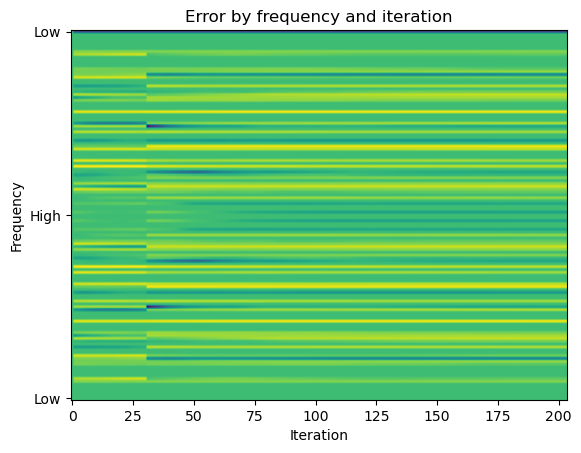

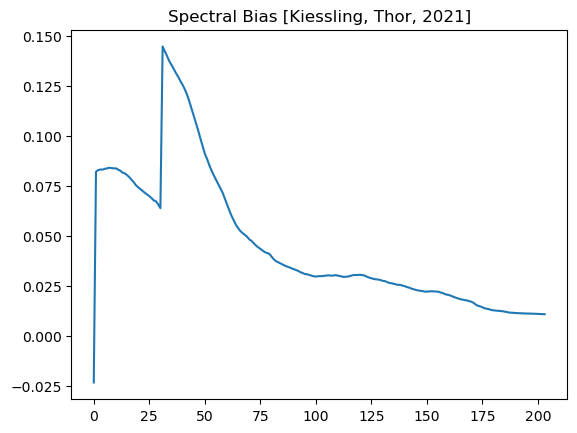

In [127]:
spec_bias_list = []
spec_cutoff_list = []
for i in range(n_iter):
    (e, k) = spectral_bias(xfft_by_iter[:, i], xfft)
    spec_bias_list.append(e)
    spec_cutoff_list.append(k)
    

err_by_iter = xfft_by_iter - xfft[:, None]

#for k in range(d):
#    plt.plot(np.log10(np.abs(err_by_iter[k, :])), label=d)
plt.title("Error by frequency and iteration")
plt.xlabel("Iteration")
plt.ylabel("Frequency")
plt.yticks([0, d//2, d-1], ["Low", "High", "Low"])
plt.imshow(np.log10(np.abs(err_by_iter)), aspect='auto')   
    
    
plt.figure()
plt.title("Spectral Bias [Kiessling, Thor, 2021]")
plt.plot(spec_bias_list)
#plt.plot(spec_cutoff_list)

### How well are the shifts estimated

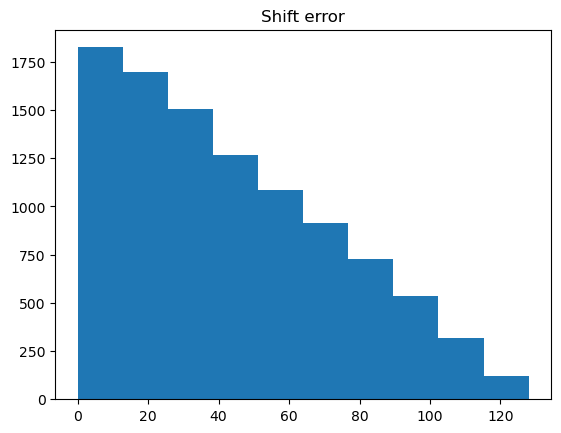

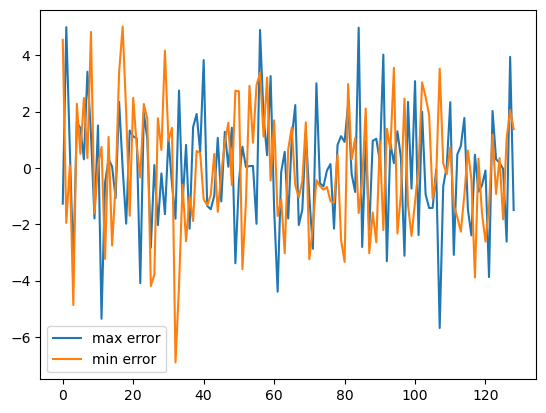

In [144]:
from src.alignment_vmap import find_shift

guess_shift = vmap(find_shift, (None, 0))(xfft, yfft)
delta_shift = np.abs(guess_shift - shift) % d

imax = np.argmax(delta_shift)
imin = np.argmin(delta_shift)

plt.hist(delta_shift)
plt.title("Shift error")

plt.figure()
plt.plot(np.roll(ifft(yfft[imax, :]).real, -shift[imax]), label='max error')
plt.plot(np.roll(ifft(yfft[imin, :]).real, -shift[imin]), label='min error')
plt.legend()

